In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
PRIMATE_DATA = 'milk.csv'
DATA_FOLDER = '../../data'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{PRIMATE_DATA}')
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


## Explanation of Columns

* kcal.per.g = kcal per gram of milk
* mass = average female body mass in kg
* neocortex.perc = percentage of total brain mass that is neocortex

In [5]:
df = df.dropna()

## Standardlize Variables

### Code 5.28

In [6]:
from scipy.stats import zscore


df['kcal.per.g_stan'] = zscore(df['kcal.per.g'])

df['log_mass_stan'] = zscore(df['mass'].apply(np.log))

df['neocortex.perc_stan'] = zscore(df['neocortex.perc']) 

## First Model

In this model, we regress the kilocalaries per gram with the neocortex mass. 
$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 1) \\
    \beta_N & \sim N(0, 1) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [7]:
with pm.Model() as m_5_5_draft:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_N = pm.Normal('beta_N', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5_draft = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 13 seconds.


## Prior Predictive Plots

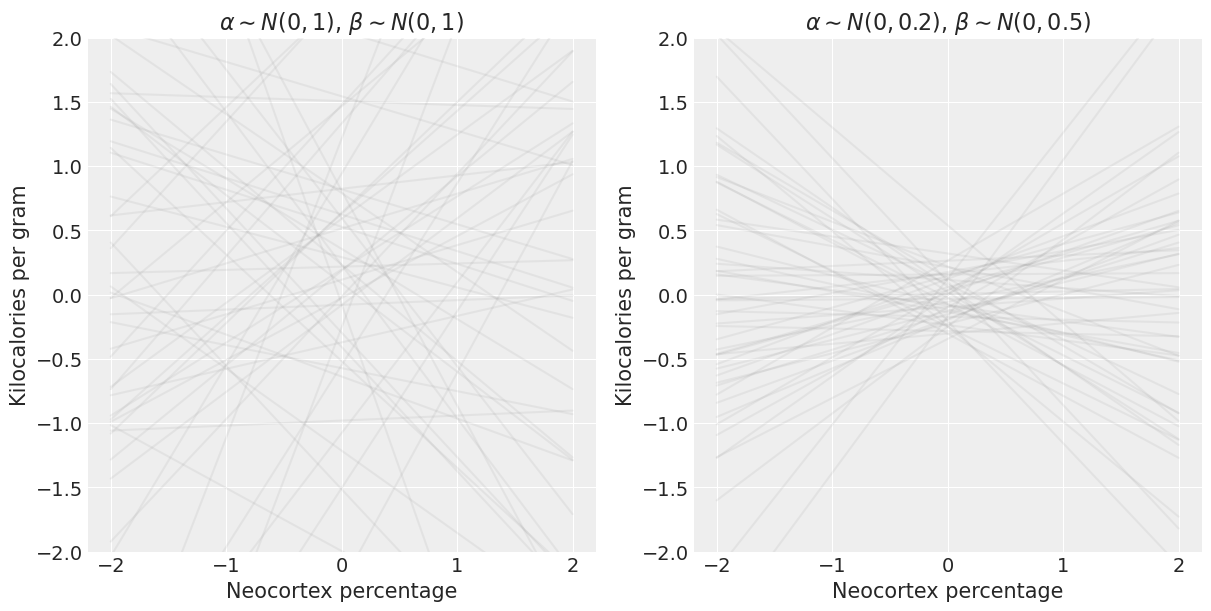

In [8]:
from scipy.stats import norm


N = 50

xvals = np.linspace(-2, 2, num=100)
a_1 = norm.rvs(loc=0, scale=1, size=N)
b_1 = norm.rvs(loc=0, scale=1, size=N)

a_2 = norm.rvs(loc=0, scale=0.2, size=N)
b_2 = norm.rvs(loc=0, scale=0.5, size=N)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(N):
    line_1 = a_1[i] + b_1[i] * xvals
    line_2 = a_2[i] + b_2[i] * xvals
    
    ax_1.plot(xvals, line_1, color='grey', alpha=0.1)
    ax_2.plot(xvals, line_2, color='grey', alpha=0.1)
    
ax_1.set_xlabel('Neocortex percentage')
ax_1.set_ylabel('Kilocalories per gram')
ax_1.set_ylim(-2, 2)

ax_2.set_xlabel('Neocortex percentage')
ax_2.set_ylabel('Kilocalories per gram')
ax_2.set_ylim(-2, 2)

ax_1.set_title(r'$\alpha \sim N(0,1)$, $\beta \sim N(0, 1)$')
ax_2.set_title(r'$\alpha \sim N(0,0.2)$, $\beta \sim N(0, 0.5)$')

plt.show()

## Second Model

Since we expect $\alpha$ to be $0$, the standard deviation is reduced to $0.2$.

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_N & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.34

In [9]:
with pm.Model() as m_5_5:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 9 seconds.


In [10]:
df_trace_5_5 = pm.trace_to_dataframe(trace_5_5)
df_trace_5_5.head()

,alpha,beta_N,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,-0.267170,0.532866,1.466055,-1.409750,-0.546550,-0.546550,-0.261270,-0.149919,-1.070175,-0.808823,-0.934898,-0.046850,-0.006359,0.268798,-0.271393,0.071863,0.195177,-0.022003,0.535672,0.461131
1,-0.091399,-0.527037,1.010968,1.038682,0.184924,0.184924,-0.097235,-0.207368,0.702822,0.444328,0.569024,-0.309309,-0.349358,-0.621504,-0.087223,-0.426724,-0.548689,-0.333884,-0.885459,-0.811734
2,-0.095086,0.344084,1.465397,-0.832876,-0.275487,-0.275487,-0.091276,-0.019374,-0.613605,-0.444843,-0.526253,0.047180,0.073327,0.251002,-0.097812,0.123836,0.203463,0.063225,0.423329,0.375196
3,0.101753,0.314671,1.531012,-0.572971,-0.063228,-0.063228,0.105238,0.170993,-0.372443,-0.218107,-0.292558,0.231858,0.255769,0.418257,0.099260,0.301961,0.374782,0.246531,0.575853,0.531835
4,0.114492,0.221549,1.849217,-0.360557,-0.001665,-0.001665,0.116945,0.163242,-0.219372,-0.110710,-0.163128,0.206094,0.222929,0.337331,0.112737,0.255452,0.306722,0.216425,0.448289,0.417297


### Code 5.35

In [11]:
az.summary(trace_5_5, var_names=['alpha', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.158,-0.243,0.259,0.001,0.001,24463.0,9202.0,24419.0,13617.0,1.0
beta_N,0.123,0.233,-0.249,0.489,0.002,0.002,22040.0,11761.0,22143.0,13771.0,1.0
sigma,1.069,0.198,0.767,1.354,0.001,0.001,18436.0,17515.0,18984.0,12209.0,1.0


In [12]:
df_mu = df_trace_5_5.filter(regex='(mu.*)')
df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,-1.409750,-0.546550,-0.546550,-0.261270,-0.149919,-1.070175,-0.808823,-0.934898,-0.046850,-0.006359,0.268798,-0.271393,0.071863,0.195177,-0.022003,0.535672,0.461131
1,1.038682,0.184924,0.184924,-0.097235,-0.207368,0.702822,0.444328,0.569024,-0.309309,-0.349358,-0.621504,-0.087223,-0.426724,-0.548689,-0.333884,-0.885459,-0.811734
2,-0.832876,-0.275487,-0.275487,-0.091276,-0.019374,-0.613605,-0.444843,-0.526253,0.047180,0.073327,0.251002,-0.097812,0.123836,0.203463,0.063225,0.423329,0.375196
3,-0.572971,-0.063228,-0.063228,0.105238,0.170993,-0.372443,-0.218107,-0.292558,0.231858,0.255769,0.418257,0.099260,0.301961,0.374782,0.246531,0.575853,0.531835
4,-0.360557,-0.001665,-0.001665,0.116945,0.163242,-0.219372,-0.110710,-0.163128,0.206094,0.222929,0.337331,0.112737,0.255452,0.306722,0.216425,0.448289,0.417297


In [13]:
mu_means = df_mu.apply(np.mean, axis=0)
mu_means.head()

mu__0   -0.263193
mu__1   -0.064119
mu__2   -0.064119
mu__3    0.001673
mu__4    0.027353
dtype: float64

### Code 5.36

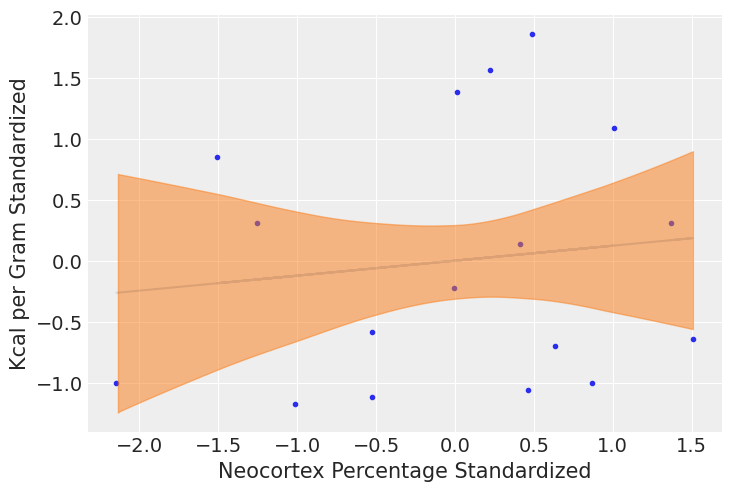

In [14]:
_, ax = plt.subplots(1, 1)

neocortex_stan = df['neocortex.perc_stan']
kcal_stan = df['kcal.per.g_stan']

ax.scatter(neocortex_stan, kcal_stan, marker='.')

ax.plot(neocortex_stan, mu_means, 'k-', alpha=0.1)

az.plot_hdi(neocortex_stan, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Neocortex Percentage Standardized')
ax.set_ylabel('Kcal per Gram Standardized')

plt.show()

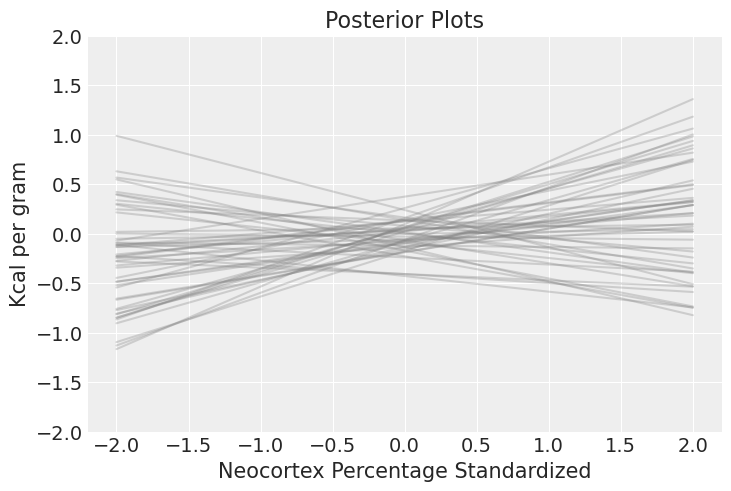

In [15]:
N = 50
xvals = np.linspace(-2, 2, num=100)

sample = df_trace_5_5[['alpha', 'beta_N']].sample(N)

_, ax = plt.subplots(1, 1)

for i in range(N):
    line = [sample.iloc[i, 0] + sample.iloc[i, 1] * x for x in xvals]
    ax.plot(xvals, line, color='grey', alpha=0.3)

ax.set_ylim(-2, 2)
ax.set_xlabel('Neocortex Percentage Standardized')
ax.set_ylabel('Kcal per gram')

plt.title('Posterior Plots')

plt.show()

## Energy vs Body Mass

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_M \cdot \log M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.37

In [16]:
with pm.Model() as m_5_6:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df['log_mass_stan'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_6 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 11 seconds.


In [17]:
az.summary(trace_5_6, var_names=['alpha', 'beta_M', 'sigma'])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.157,-0.288,0.301,0.001,0.001,23153.0,8947.0,23189.0,13993.0,1.0
beta_M,-0.283,0.224,-0.701,0.144,0.002,0.001,21754.0,17883.0,21940.0,14041.0,1.0
sigma,1.019,0.193,0.703,1.384,0.001,0.001,17322.0,16252.0,17690.0,11689.0,1.0


In [18]:
df_tr_5_6 = pm.trace_to_dataframe(trace_5_6)
df_tr_5_6.head()

,alpha,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,-0.247091,0.417856,1.338014,-0.432365,-0.211681,-0.206646,-0.376113,-0.667108,-1.053618,-0.749410,-0.835066,-0.483520,-0.319228,-0.021976,-0.206646,0.214076,0.393651,0.244880,0.198672,0.311551
1,0.058825,-0.643920,0.916342,0.344334,0.004259,-0.003502,0.257649,0.706075,1.301689,0.832903,0.964899,0.423164,0.169989,-0.288079,-0.003502,-0.651838,-0.928564,-0.699306,-0.628099,-0.802048
2,0.058825,-0.643920,0.916342,0.344334,0.004259,-0.003502,0.257649,0.706075,1.301689,0.832903,0.964899,0.423164,0.169989,-0.288079,-0.003502,-0.651838,-0.928564,-0.699306,-0.628099,-0.802048
3,0.162484,0.159834,0.932782,0.091615,0.176029,0.177955,0.113132,0.001824,-0.146020,-0.029658,-0.062422,0.072048,0.134891,0.248593,0.177955,0.338885,0.407575,0.350668,0.332993,0.376171
4,-0.135942,-0.344319,1.436794,0.016726,-0.165120,-0.169270,-0.029626,0.210158,0.528647,0.277976,0.348558,0.058879,-0.076500,-0.321440,-0.169270,-0.515951,-0.663923,-0.541333,-0.503257,-0.596272


In [19]:
df_mu_5_6 = df_tr_5_6.filter(regex='mu.*')
mu_means_5_6 = df_mu_5_6.apply(np.mean) 

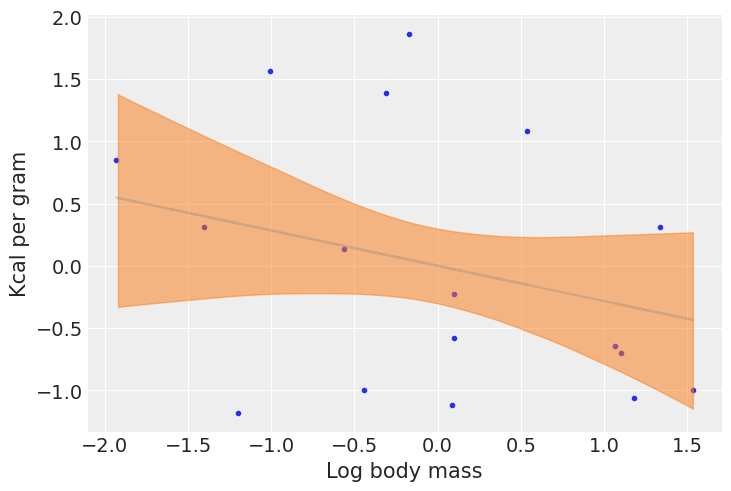

In [20]:
_, ax = plt.subplots(1, 1)

ax.scatter(df['log_mass_stan'], df['kcal.per.g_stan'], marker='.')
ax.plot(df['log_mass_stan'], mu_means_5_6, color='grey', alpha=0.3)

az.plot_hdi(df['log_mass_stan'], np.expand_dims(df_mu_5_6.values, 0), ax=ax)

ax.set_xlabel('Log body mass')
ax.set_ylabel('Kcal per gram')

plt.show()

## Joint Regression Model

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_M \cdot \log M_i + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \beta_N & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.38

In [21]:
with pm.Model() as m_5_7:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    beta_N = pm.Normal('beta_N', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df['log_mass_stan'] + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_7 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 12 seconds.


In [22]:
az.summary(trace_5_7, var_names=['alpha', 'beta_M', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.142,-0.223,0.227,0.001,0.001,13058.0,8993.0,13080.0,12128.0,1.0
beta_M,-0.677,0.262,-1.082,-0.257,0.003,0.002,8975.0,8975.0,9153.0,10619.0,1.0
beta_N,0.573,0.263,0.155,0.988,0.003,0.002,8881.0,8881.0,8959.0,11670.0,1.0
sigma,0.831,0.171,0.579,1.088,0.002,0.001,9179.0,9179.0,8876.0,8181.0,1.0


In [23]:
summary_5_5 = az.summary(trace_5_5, hdi_prob=0.89)
summary_5_6 = az.summary(trace_5_6, hdi_prob=0.89)
summary_5_7 = az.summary(trace_5_7, hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less 

### Code 5.39

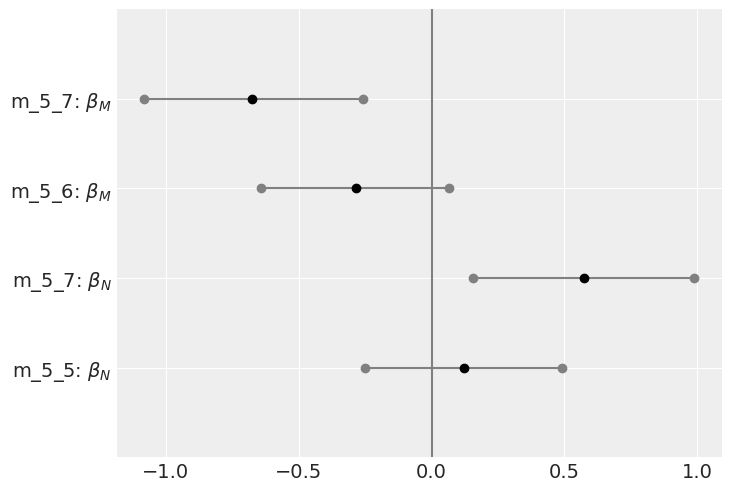

In [24]:
summary_list = [(summary_5_5, 'beta_N', 1), 
                (summary_5_7, 'beta_N', 2), 
                (summary_5_6, 'beta_M', 3), 
                (summary_5_7, 'beta_M', 4)]


_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'o-', color='grey')
    ax.plot((mid), (y_level), 'ko')

ax.vlines(x=0, ymin=0, ymax=5, color='grey')
ax.set_ylim(0, 5)
plt.yticks([1, 2, 3, 4], [r'm_5_5: $\beta_N$', r'm_5_7: $\beta_N$', r'm_5_6: $\beta_M$', r'm_5_7: $\beta_M$'])

plt.show()

In [25]:
df[['log_mass_stan', 'neocortex.perc_stan']].corr()

,log_mass_stan,neocortex.perc_stan
log_mass_stan,1.000000,0.750376
neocortex.perc_stan,0.750376,1.000000


## Discussion

In this case, we have a response variable $Y$ and two predictor variables $X_1$ and $X_2$, where both predictor variables are strongly correlated with one another. The reponse $Y$, however, is positively correlated with $X_1$ and negatively correlated with $X_2$. When we regress $Y$ against both $X_1$ and $X_2$, the slopes $b_{X_1}$ and $b_{X_2}$ are greater than when $Y$ is regressed against $X_1$ alone or against $X_2$ alone. In the joint regression, $X_1$ and $X_2$ tend to cancel each other out.  